In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [48]:
def extract(data_dir, prefix, start_week, end_week):
    """ Extract a temporal slice of data for a given data source.
    
    Parameters
    ----------
    data_dir: str
        Data directory path.
    start_week: int
        First week number (included)
    end_week: int
        Last week number (included)
    prefix: str
        Data source identification (e.g. restaurant_1)
    """
    df = pd.DataFrame()
    
    for i in range(start_week, end_week+1):
        file_path = os.path.join(data_dir, 'data', f'{prefix}_week_{i}.csv')

        if os.path.isfile(file_path):
            batch = pd.read_csv(file_path)
            df = pd.concat([df, batch], sort=True)
    
    return df

def clean(df):
    """Clean dataframe."""
    
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    df['order_date'] = pd.to_datetime(df['order_date'])
    df = df.rename(columns={'order_number': 'order_id'})
    df = df.sort_values('order_date')
    df['total_product_price'] = df['quantity'] * df['product_price']
    df['cash_in'] = df.groupby('order_id')['total_product_price'].transform(np.sum)
    df = df.drop(columns=['item_name', 'quantity', 'product_price', 
                          'total_products', 'total_product_price'],
                errors="ignore")
    df = df.drop_duplicates()
    df = df.reset_index(drop=True)
    return df

def merge(df1, df2):
    df = pd.concat([df1, df2])
    df = df.drop(columns = ['order_id'])
    df = df.sort_values('order_date')
    df = df.reset_index(drop=True)
    return df

def resample(df): 
    df = df.resample('1H', on='order_date').sum().reset_index()
    return df

In [54]:
# Restaurant 1
df1 = extract(data_dir= "/Users/CORENTIN/data-corentinv/tp-intro-mlops",
       prefix="restaurant_1" , start_week=108, end_week=110)
df1 = clean(df1)

In [50]:
# Restaurant 2
df2 = extract(data_dir= "/Users/CORENTIN/data-corentinv/tp-intro-mlops",
       prefix="restaurant_2" , start_week=108, end_week=110)
df2 = clean(df2)

In [51]:
df = merge(df1, df2)
df

In [52]:
df = resample(df)
df.head()

,order_date,cash_in
0,2017-01-23 16:00:00,80.40
1,2017-01-23 17:00:00,66.70
2,2017-01-23 18:00:00,64.00
3,2017-01-23 19:00:00,219.05
4,2017-01-23 20:00:00,111.25


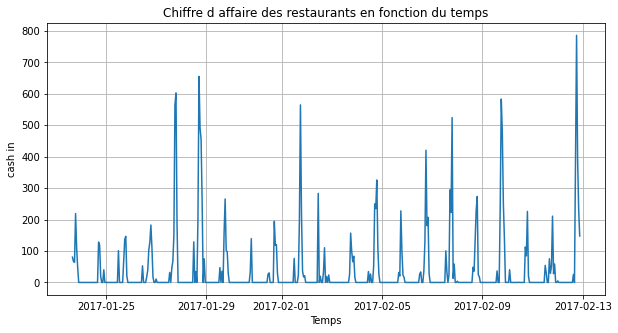

In [53]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(df['order_date'], df['cash_in'])
ax.set_title('Chiffre d affaire des restaurants en fonction du temps')
ax.set_xlabel('Temps')
ax.set_ylabel('cash in')
plt.grid(True)